# Example of CO2-only runs

In [1]:
import numpy as np
import pandas as pd
import textwrap
from mce.util.plot_base import PlotBase
from mce.core.forcing import RfCO2
from mce.core.driver import Driver

## Plot settings

In [2]:
myplt = PlotBase()

In [3]:
def plot_timeseries(times, rets, labels, variables, vnames=[], **kw):
    """Time series plot for multiple variables

    Parameters
    ----------
    times
        Time points
    rets
        Output data
    labels
        Case labels
    variables
        Variable attributes
    vnames, optional
        Variables to be plotted.
        When the output data are given with DataFrame,
        their columns are used
    """
    ret0 = rets[0]
    if not vnames:
        vnames = list(ret0)
    
    kw_space = kw.get(
        'kw_space',
        {'height': 2.7, 'wspace': 1.1, 'hspace': 1.},
    )
    col = kw.get('col', 3)
    myplt.init_regular(len(vnames), col, kw_space=kw_space)

    n = 0
    vnames2 = []
    
    for vn in vnames:
        if ret0[vn].ndim == 2:
            vnames2.append(vn)
            continue
        
        ax = myplt(n)

        for time, ret, label in zip(times, rets, labels):
            ax.plot(time, ret[vn], label=label)

        ax.legend()
        ax.set_xlabel('Time (yr)')
        att = variables[vn]
        ax.set_ylabel(f'({att.units})')
        ax.set_title('\n'.join(textwrap.wrap(att.long_name, 40)))
        ax.grid()

        n = n+1

    for vn in vnames2:
        ax = myplt(n)

        for time, ret, label in zip(times, rets, labels):
            for k in range(3):
                ax.plot(time, ret[vn][k], label=f'{label}|{vn}[{k}]')

        for i, line in enumerate(ax.lines):
            line.set_color('C{}'.format(int(i/3)))
            line.set_linestyle(['-', '--', ':'][i%3])

        ax.set_xlabel('Time (yr)')
        att = variables[vn]
        ax.set_ylabel(f'({att.units})')
        ax.set_title('\n'.join(textwrap.wrap(att.long_name, 40)))

        if n == len(vnames)-1:
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.))

        ax.grid()
        n = n+1

## 1. Emission-driven runs

The driver requires time points in years and emissions in GtC/yr at the time points.

The time points are not necessarily equally-spaced. 
The driver calculates input emissions with a fixed time step, default 1 year, by linear interpolation.

In [4]:
def bell_shaped_emissions():
    """Create bell-shaped emissions pathways
    Adopted from Jones et al. (2019, https://doi.org/10.5194/gmd-12-4375-2019)

    Returns
    -------
        Emissions in DataFrame
    """
    Period = 96
    CumulativeE = [750, 1000, 2000]
    m = np.size(CumulativeE)
    Time = np.arange(0.5, 200.5, 1)
    t = np.size(Time)
    Pathways = np.zeros((t, m))

    for j in range(0, m):
        SD = Period / 6
        CE = CumulativeE[j] / 0.997300204
        Mu = Period / 2
        Emissions = CE *(
            (1/(SD*np.sqrt(2*np.pi)))*np.exp(-0.5*(((Time-Mu)/SD)**2))
        )
        Emissions[Period:] = 0
        Pathways[:,j] = Emissions

    df = pd.DataFrame(
        Pathways, index=Time, columns=[f'{x} GtC' for x in CumulativeE],
    )

    return df

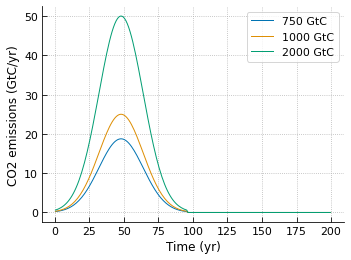

In [5]:
dfin = bell_shaped_emissions()

myplt.init_general()
ax = myplt(0)
ax.plot(dfin.index, dfin)
ax.legend(ax.lines, dfin.columns)
ax.set_xlabel('Time (yr)')
ax.set_ylabel('CO2 emissions (GtC/yr)')
ax.grid()

In [6]:
# Perform emissions-driven runs
time = dfin.index.values
rets_edrv = []

for k, d1 in dfin.items():
    drv = Driver(time, eco2=d1.values)
    rets_edrv.append(drv.run())

In [7]:
# Output variables
ret0 = rets_edrv[0]
for k in sorted(ret0):
    print(k, ret0[k].shape, '{} ({})'.format(*drv.variables[k]))

abf (200,) Airborne fraction of cumulative CO2 emissions (Dimensionless)
catm (200,) Excess carbon in the atmosphere (Gt C)
cbs (4, 200) Accumulated carbon over land (Gt C)
cbsf (200,) Atmosphere-to-land CO2 flux (Gt C/yr)
cbst (200,) Accumulated total carbon over land (Gt C)
cco2 (200,) Atmospheric CO2 concentration (ppm)
cocf (200,) Atmosphere-to-ocean CO2 flux (Gt C/yr)
coct (200,) Accumulated total carbon over ocean (Gt C)
ctot (200,) Cumulative CO2 emissions (Gt C)
eco2 (200,) CO2 emissions (Gt C/yr)
erf (200,) Total effective radiative forcing (W/m^2)
erf|CO2 (200,) Effective radiative forcing of CO2 (W/m^2)
rtnt (200,) Total heat uptake (W/m^2)
tak (3, 200) Temperature change (K)
tas (200,) Surface temperature change (K)
tcre (200,) Instantaneous TCRE (K/1000 Gt C)
thc (200,) Total heat content change (J/spy/m^2)


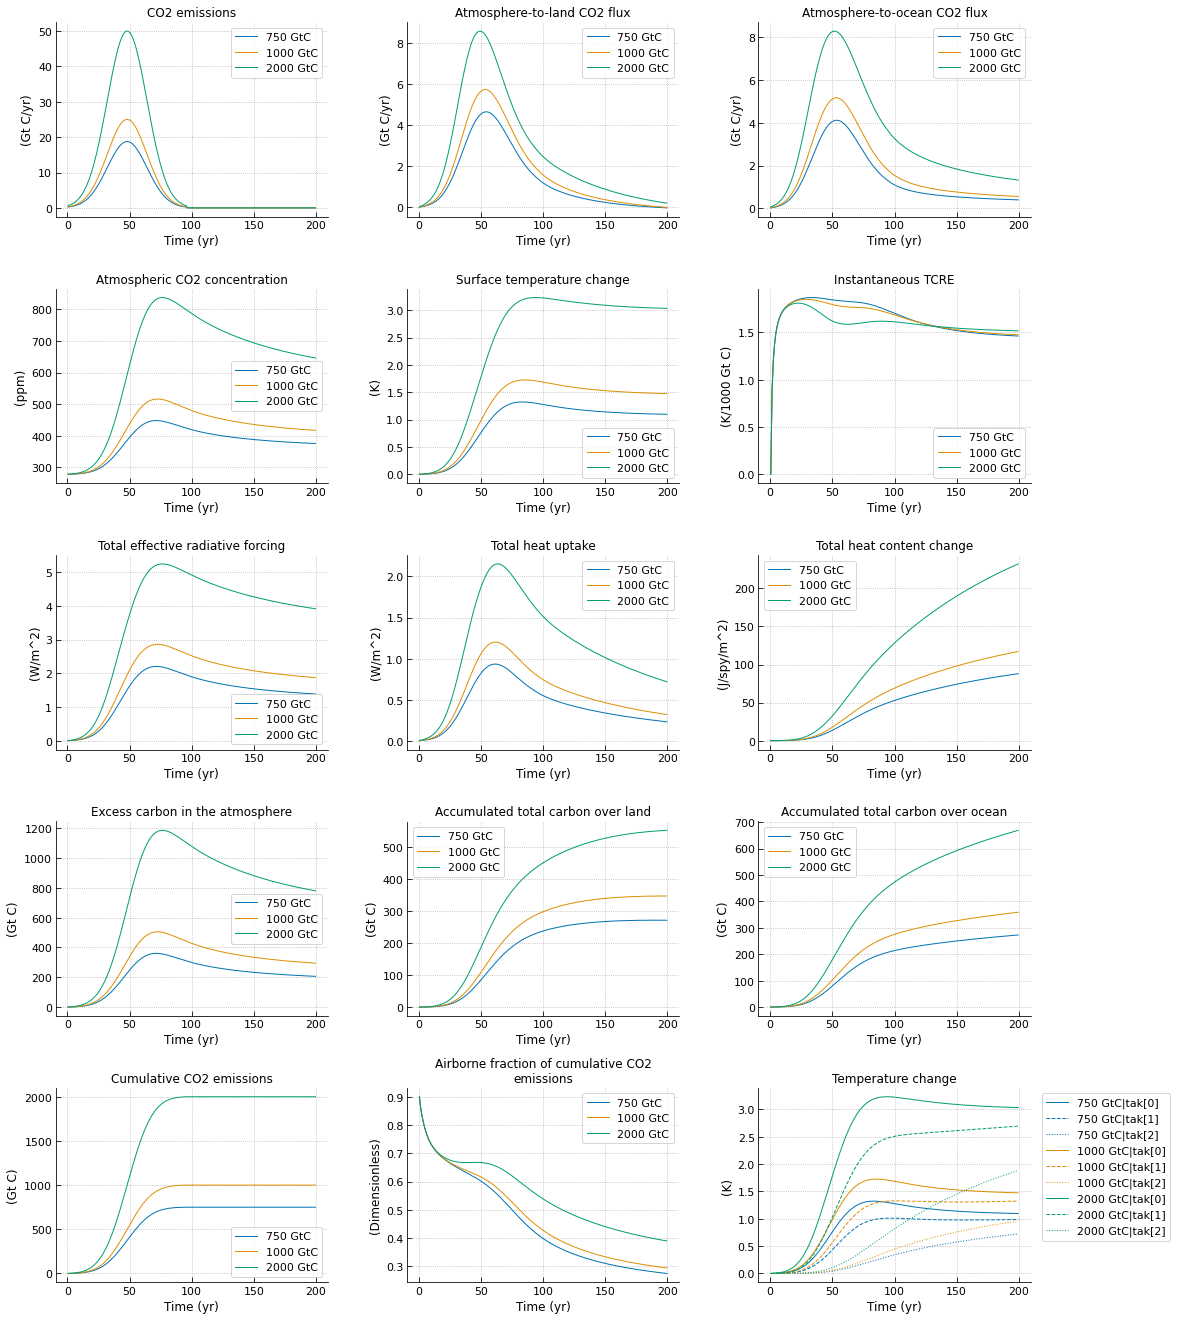

In [8]:
vnames = [
    'eco2', 'cbsf', 'cocf',
    'cco2', 'tas', 'tcre',
    'erf', 'rtnt', 'thc',
    'catm', 'cbst', 'coct',
    'ctot', 'abf', 'tak',
]
plot_timeseries([drv.time]*3, rets_edrv, list(dfin), drv.variables, vnames)

## 2. Concentration-driven runs

In [9]:
# using the output of the emission-driven runs
rets_cdrv = []
for ret1 in rets_edrv:
    drv = Driver(time, cco2=ret1['cco2'])
    rets_cdrv.append(drv.run())

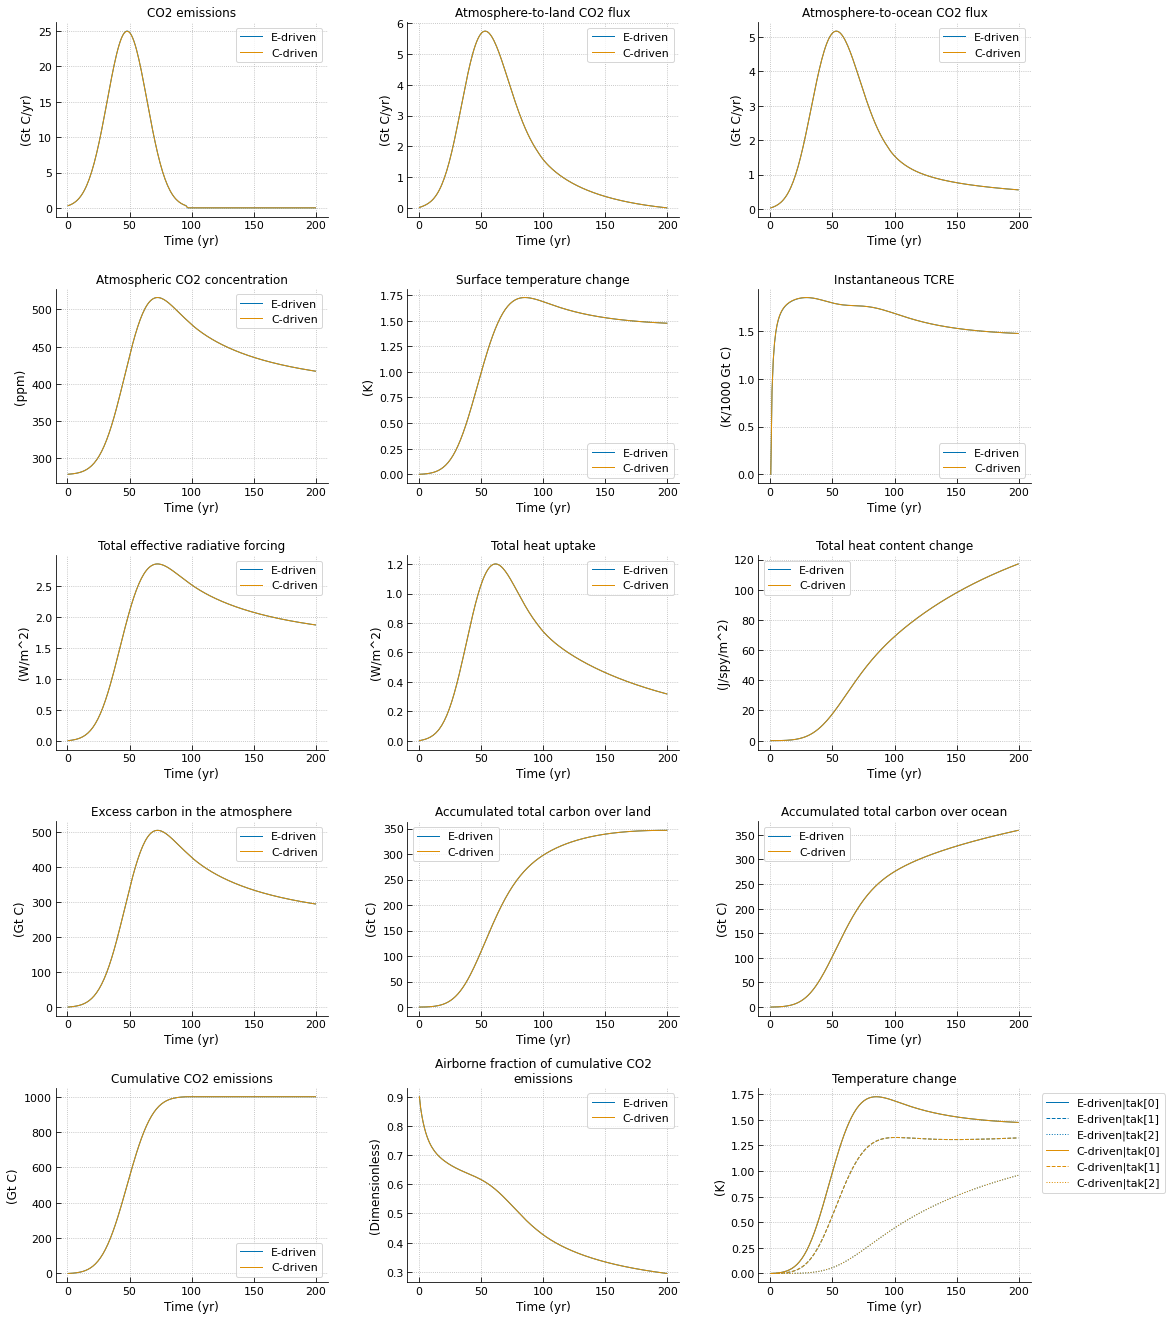

In [10]:
# Comparison between emission- and concentration-driven runs
plot_timeseries(
    [time]*2, [rets_edrv[1], rets_cdrv[1]],
    ['E-driven', 'C-driven'], drv.variables, vnames,
)

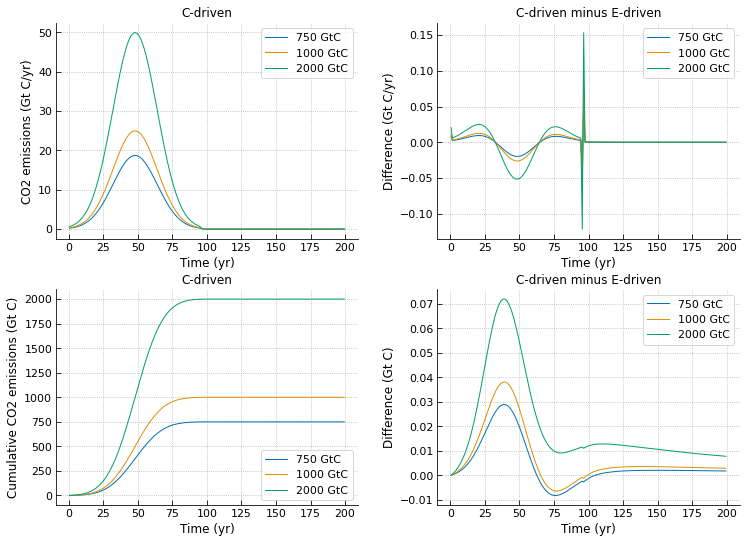

In [11]:
# Comparison focusing on implied CO2 emissions
# In this case, there are small discontinuous differences where emissions reach zero
vnames = ['eco2', 'ctot']

myplt.init_regular(len(vnames)*2, col=2, kw_space={'wspace': 1.1})

for i, vn in enumerate(vnames):
    df = pd.DataFrame({
        label: ret1[vn] for label, ret1 in zip(dfin, rets_cdrv)
    }, index=time)
    df_diff = pd.DataFrame({
        label: ret1_cdrv[vn] - ret1_edrv[vn]
        for label, ret1_edrv, ret1_cdrv in zip(dfin, rets_edrv, rets_cdrv)
    }, index=time)
    
    ax = myplt(2*i)
    ax.plot(df.index, df)
    ax.legend(ax.lines, df.columns)
    ax.set_xlabel('Time (yr)')
    ax.set_ylabel('\n'.join(textwrap.wrap(
        '{} ({})'.format(*drv.variables[vn]), 40
    )))
    ax.set_title('C-driven')
    ax.grid()
    
    ax = myplt(2*i+1)
    ax.plot(df_diff.index, df_diff)
    ax.legend(ax.lines, df_diff.columns)
    ax.set_xlabel('Time (yr)')
    ax.set_ylabel('Difference ({})'.format(drv.variables[vn].units))
    ax.set_title('C-driven minus E-driven')
    ax.grid()

## 3. Emission-driven run using a larger time step

In the following example, time step is set to 10 years, instead of default 1 year.
Input emissions are given at 1-year spacing points as in the above,
but to be looked up by 10 years in the time integration.

The accuracy of time integrations depends on the solver employed in the driver,
scipy.integrate.solve_ivp,
which uses an explicit Runge-Kutta method of order 5(4) (RK45) as default.

In [12]:
dt = 10
drv = Driver(time, eco2=dfin['1000 GtC'].values, dt=dt)
ret1_ls = drv.run()

In [13]:
# Time points are retrieved from drv.time
drv.time

array([  0.5,  10.5,  20.5,  30.5,  40.5,  50.5,  60.5,  70.5,  80.5,
        90.5, 100.5, 110.5, 120.5, 130.5, 140.5, 150.5, 160.5, 170.5,
       180.5, 190.5])

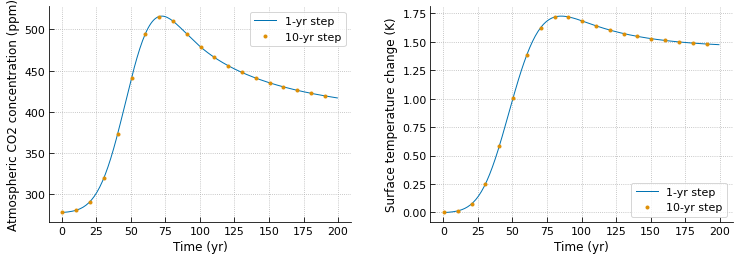

In [14]:
vnames = ['cco2', 'tas']

myplt.init_regular(len(vnames), col=2, kw_space={'wspace': 1.1})

for i, vn in enumerate(vnames):
    ax = myplt(i)
    ax.plot(time, rets_edrv[1][vn], label='1-yr step')
    ax.plot(drv.time, ret1_ls[vn], '.', label=f'{dt}-yr step')
    ax.legend()
    ax.set_xlabel('Time (yr)')
    ax.set_ylabel('\n'.join(textwrap.wrap(
        '{} ({})'.format(*drv.variables[vn]), 40
    )))
    ax.grid()

## 4. Use of custom output

New variables can be derived from existing variables in reversed Polish notation. The followings are simple derivations of the surface air-ocean blended temperature changes and ocean heat content changes from native variables of the surface air temperature changes and the total heat content changes.

In [15]:
variables = ['tas', 'thc']
variables_derived = [
    ('gmst', ['tas', 1.04, '/'],
     'Surface air ocean blended temperature change', 'degC'),
    ('ohc', ['thc', 1.08, '/'],
     'Ocean heat content change', 'J/spy/m^2'),
]

# Units conversions can be applied if needed.
seconds_per_year = 3.15569e7
earth_area = 5.10e14 # m^2
conversion = [
    ('thc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
    ('ohc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
]

outform = {
    'variables': variables,
    'variables_derived': variables_derived,
    'conversion': conversion,
}

dfout = drv.run(outform=outform)

In [16]:
# The output is in DataFrame
dfout

,0.5,10.5,20.5,30.5,40.5,50.5,60.5,70.5,80.5,90.5,100.5,110.5,120.5,130.5,140.5,150.5,160.5,170.5,180.5,190.5
tas,0.0,0.014289,0.076271,0.251867,0.583558,1.008117,1.387805,1.625497,1.717600,1.718724,1.682817,1.640376,1.603068,1.572312,1.547476,1.527541,1.511569,1.498791,1.488594,1.480484
thc,0.0,2.128843,14.140641,53.943662,144.602696,293.017060,478.594223,668.868208,841.043814,988.930728,1116.230863,1228.220842,1329.031981,1420.826717,1504.916034,1582.241692,1653.554155,1719.482619,1780.566438,1837.272443
gmst,0.0,0.013740,0.073337,0.242180,0.561114,0.969343,1.334428,1.562978,1.651538,1.652619,1.618093,1.577285,1.541412,1.511839,1.487958,1.468789,1.453431,1.441146,1.431340,1.423542
ohc,0.0,1.971151,13.093186,49.947836,133.891385,271.312092,443.142800,619.322415,778.744273,915.676600,1033.547096,1137.241521,1230.585168,1315.580294,1393.440772,1465.038604,1531.068662,1592.113536,1648.672627,1701.178188


In [17]:
# Derived variables and units conversion are reflected in drv.variables
for name in dfout.index:
    print(name, '{} ({})'.format(*drv.variables[name]))

tas Surface temperature change (K)
thc Total heat content change (ZJ)
gmst Surface air ocean blended temperature change (degC)
ohc Ocean heat content change (ZJ)


## 5. Climate-only runs

The followings are two CMIP basic experiments, abrupt quadrupling (`abrupt-4xCO2`) and 1%-per-year increase ('1pctCO2') in CO2 concentrations. In climate-only runs, time integrations use `response` method of the climate module instead of RK45.

In [18]:
forcing = RfCO2()
cco2_pi = forcing.parms.ccref
kw = {'irm_only': True}

# abrupt-4xCO2
# two data points are enough
drv_4x = Driver([0, 150], [cco2_pi*4]*2)
ret_4x = drv_4x.run(**kw)

# 1pctCO2
time = np.arange(0, 140)
cco2 = cco2_pi * 1.01**time
drv_1p = Driver(time, cco2=cco2)
ret_1p = drv_1p.run(**kw)

# 1pctCO2 with Non-CO2 forcing
erf_nonco2 = ret_1p['erf'] * 0.2
drv_1pn = Driver(time, cco2=cco2, erf_nonco2=erf_nonco2)
ret_1pn = drv_1pn.run(**kw)

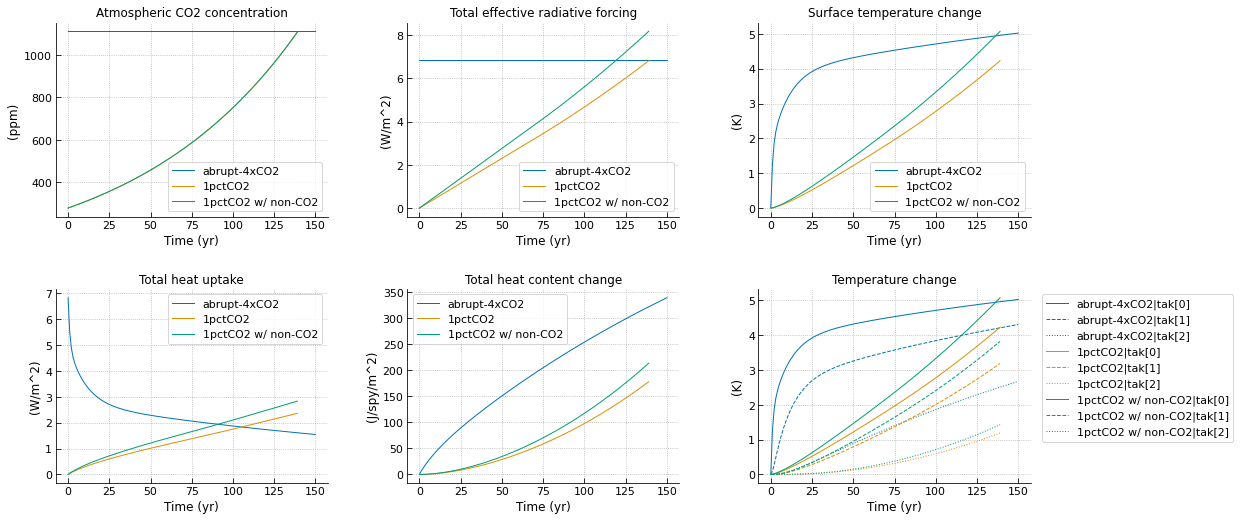

In [19]:
vnames = ['cco2', 'erf', 'tas', 'rtnt', 'thc', 'tak']

plot_timeseries(
    [drv_4x.time, drv_1p.time, drv_1pn.time],
    [ret_4x, ret_1p, ret_1pn],
    ['abrupt-4xCO2', '1pctCO2', '1pctCO2 w/ non-CO2'],
    drv_4x.variables, vnames=vnames,
)